# Hometown - Analytics Case
## Pipeline principal - Dados de Aerogeradores SIGEL/ANEEL

Este notebook implementa um pipeline completo e idempotente para:
- **Extração** de dados da API SIGEL/ANEEL
- **Transformação** de JSON para Parquet otimizado
- **Consolidação** em CSV final para Tableau

### Características do Pipeline:
- **Idempotente**: Não reprocessa dados desnecessariamente
- **Baseado em dados**: Usa `DATA_ATUALIZACAO` da própria API
- **Paralelo**: ThreadPool para performance
- **Robusto**: Retry, validações e logs detalhados
- **Limpo**: Auto-limpeza de dados antigos

---
## 1. Setup e configuração inicial

Configuração do ambiente, imports e validação da conectividade com a API.

In [1]:
# Imports básicos e configuração de paths
import sys
import json
from pathlib import Path
import pandas as pd

# Configurar path do projeto
project_root = Path.cwd().parent
src_path = project_root / "src"
sys.path.insert(0, str(src_path))

print("🔧 Configuração do ambiente...")
print(f"Projeto root: {project_root}")
print(f"Src path: {src_path}")
print("✅ Paths configurados!")

🔧 Configuração do ambiente...
Projeto root: /home/victor-jose/Documents/projetos/hometown
Src path: /home/victor-jose/Documents/projetos/hometown/src
✅ Paths configurados!


In [2]:
# Imports dos módulos do projeto
from extraction.extractors import SigelExtractor
from extraction.validators import validate_api_connection, validate_extraction_results
from transformation.processors import DataProcessor
from consolidation.consolidators import DataConsolidator
from config.settings import SIGEL_CONFIG
from utils.logger import setup_logger
from utils.exceptions import APIConnectionError, ValidationError

# Setup do logger principal
logger = setup_logger(__name__, "pipeline.log")

print("Módulos importados com sucesso!")
print(f"API URL: {SIGEL_CONFIG['url']}")
print(f"Tamanho da página: {SIGEL_CONFIG['page_size']} registros")
print("✅ Setup concluído!")

Módulos importados com sucesso!
API URL: https://sigel.aneel.gov.br/arcgis/rest/services/PORTAL/WFS/MapServer/0/query
Tamanho da página: 1000 registros
✅ Setup concluído!


### Validação da conectividade

Testa a conexão com a API SIGEL/ANEEL antes de iniciar o pipeline.

In [3]:
# Testar conectividade com a API
try:
    print("🌐 Testando conectividade com a API SIGEL/ANEEL...")
    
    api_url = SIGEL_CONFIG["url"]
    connection_ok = validate_api_connection(api_url)
    
    if connection_ok:
        print("✅ API conectada com sucesso!")
        logger.info("Validação de conectividade concluída com sucesso")
    else:
        print("❌ Falha na conexão com API")
        
except (APIConnectionError, ValidationError) as e:
    print(f"❌ Erro de validação: {e}")
    logger.error(f"Erro de validação: {e}")
except Exception as e:
    print(f"❌ Erro inesperado: {e}")
    logger.error(f"Erro inesperado durante validação: {e}")

🌐 Testando conectividade com a API SIGEL/ANEEL...
2025-06-02 00:29:53 - extraction.validators - INFO - API conectada com sucesso. Total de registros: 23522
✅ API conectada com sucesso!
2025-06-02 00:29:53 - __main__ - INFO - Validação de conectividade concluída com sucesso


---
## 2. Comandos de limpeza e manutenção

Funções utilitárias para gerenciar dados e fazer limpeza quando necessário.

In [4]:
def show_current_data_status():
    """Exibe status atual dos dados no projeto"""
    print("STATUS ATUAL DOS DADOS:")
    print("="*40)
    
    # Contar arquivos em cada etapa
    raw_files = list(Path("data/raw").glob("aerogeradores_raw_*.json")) if Path("data/raw").exists() else []
    processed_files = list(Path("data/processed").glob("aerogeradores_processed_*.parquet")) if Path("data/processed").exists() else []
    output_files = list(Path("data/output").glob("aerogeradores_consolidado_*.csv")) if Path("data/output").exists() else []
    
    print(f"Arquivos JSON (raw): {len(raw_files)}")
    print(f"Arquivos Parquet (processed): {len(processed_files)}")
    print(f"Arquivos CSV (output): {len(output_files)}")
    
    # Calcular tamanhos
    total_size = 0
    for files, label in [(raw_files, "JSONs"), (processed_files, "Parquets"), (output_files, "CSVs")]:
        if files:
            size = sum(f.stat().st_size for f in files) / 1024 / 1024
            total_size += size
            print(f"Tamanho {label}: {size:.2f} MB")
    
    print(f"Tamanho total: {total_size:.2f} MB")
    
    return {
        'raw_count': len(raw_files),
        'processed_count': len(processed_files),
        'output_count': len(output_files),
        'total_size_mb': total_size
    }

def cleanup_all_data():
    """Remove todos os dados para recomeçar do zero"""
    print("INICIANDO LIMPEZA COMPLETA...")
    
    # Instanciar classes para usar métodos de limpeza
    extractor = SigelExtractor()
    processor = DataProcessor()
    consolidator = DataConsolidator()
    
    # Executar limpeza de cada etapa
    raw_removed = extractor.cleanup_all_raw_data()
    processed_removed = processor.cleanup_all_processed_data()
    output_removed = consolidator.cleanup_all_output_data()
    
    total_removed = raw_removed + processed_removed + output_removed
    
    print(f"RESUMO DA LIMPEZA:")
    print(f"  JSONs removidos: {raw_removed}")
    print(f"  Parquets removidos: {processed_removed}")
    print(f"  CSVs removidos: {output_removed}")
    print(f"  Total de arquivos: {total_removed}")
    print(f"✅ Limpeza completa concluída!")
    
    return total_removed

# Mostrar status inicial
status = show_current_data_status()

print("\n" + "="*50)
print("COMANDOS DISPONÍVEIS:")
print("• show_current_data_status() - Mostra status dos dados")
print("• cleanup_all_data() - Remove todos os dados")
print("="*50)

STATUS ATUAL DOS DADOS:
Arquivos JSON (raw): 0
Arquivos Parquet (processed): 0
Arquivos CSV (output): 0
Tamanho total: 0.00 MB

COMANDOS DISPONÍVEIS:
• show_current_data_status() - Mostra status dos dados
• cleanup_all_data() - Remove todos os dados


---
## 🚀 3. Pipeline principal - extração de dados

Extração idempotente de dados da API SIGEL/ANEEL. O sistema verifica automaticamente se os dados mudaram na API antes de fazer nova extração.

In [5]:
# Instanciar extrator e verificar freshness dos dados
print("🔍 VERIFICANDO FRESHNESS DOS DADOS...")
print("="*50)

extractor = SigelExtractor()
freshness = extractor.check_data_freshness()

print(f"STATUS DOS DADOS:")
print(f"  API última atualização: {freshness['api_latest_update']}")
print(f"  Nossa última extração: {freshness['our_last_extraction']}")
print(f"  Precisa atualizar: {freshness['needs_refresh']}")

if freshness['last_extraction_time']:
    print(f"  Última extração em: {freshness['last_extraction_time']}")
    print(f"  Registros da última extração: {freshness['last_total_records']:,}")
else:
    print(f"  Primeira execução - nenhuma extração anterior")

print("\n" + "="*50)

🔍 VERIFICANDO FRESHNESS DOS DADOS...
2025-06-02 00:29:53 - extraction.extractors - INFO - Verificando freshness dos dados...
2025-06-02 00:29:55 - extraction.extractors - INFO - API última atualização: 1673359590000
2025-06-02 00:29:55 - extraction.extractors - INFO - Nossa última extração: 0
2025-06-02 00:29:55 - extraction.extractors - INFO - Precisa atualizar: True
STATUS DOS DADOS:
  API última atualização: 1673359590000
  Nossa última extração: 0
  Precisa atualizar: True
  Primeira execução - nenhuma extração anterior



In [6]:
# Executar extração (idempotente - só extrai se necessário)
print("EXECUTANDO EXTRAÇÃO DE DADOS...")
print("(O sistema decide automaticamente se precisa extrair baseado na DATA_ATUALIZACAO da API)\n")

try:
    # Extração idempotente (force_refresh=False por padrão)
    saved_files = extractor.extract_all_data()
    
    print(f"\nRESULTADO DA EXTRAÇÃO:")
    print(f"✅ Arquivos JSON salvos: {len(saved_files)}")
    
    if saved_files:
        # Mostrar alguns arquivos como exemplo
        print(f"\nArquivos salvos (primeiros 3):")
        for i, file_path in enumerate(saved_files[:3]):
            filename = Path(file_path).name
            size = Path(file_path).stat().st_size / 1024  # KB
            print(f"  {i+1}. {filename} ({size:.1f} KB)")
        
        if len(saved_files) > 3:
            print(f"  ... e mais {len(saved_files) - 3} arquivos")
        
        # Calcular tamanho total
        total_size = sum(Path(f).stat().st_size for f in saved_files) / 1024 / 1024
        print(f"\nTamanho total: {total_size:.2f} MB")
        print(f"Localização: data/raw/")
    
    logger.info(f"Extração concluída: {len(saved_files)} arquivos")
    
except Exception as e:
    print(f"❌ Erro durante extração: {e}")
    logger.error(f"Erro durante extração: {e}")
    raise

EXECUTANDO EXTRAÇÃO DE DADOS...
(O sistema decide automaticamente se precisa extrair baseado na DATA_ATUALIZACAO da API)

2025-06-02 00:29:55 - extraction.extractors - INFO - Verificando freshness dos dados...
2025-06-02 00:29:56 - extraction.extractors - INFO - API última atualização: 1673359590000
2025-06-02 00:29:56 - extraction.extractors - INFO - Nossa última extração: 0
2025-06-02 00:29:56 - extraction.extractors - INFO - Precisa atualizar: True
2025-06-02 00:29:56 - extraction.extractors - INFO - Dados da API foram atualizados, executando nova extração...
2025-06-02 00:30:27 - extraction.extractors - WARNING - Tentativa 1 falhou: HTTPSConnectionPool(host='sigel.aneel.gov.br', port=443): Read timed out. (read timeout=30). Tentando novamente em 1s...
2025-06-02 00:30:42 - extraction.extractors - INFO - Total de registros: 23522
2025-06-02 00:30:42 - extraction.extractors - INFO - Total de páginas: 24
2025-06-02 00:30:42 - extraction.extractors - INFO - Data de atualização da API: 

In [7]:
# Validação dos dados extraídos
if 'saved_files' in locals() and saved_files:
    print("VALIDANDO DADOS EXTRAÍDOS...")
    
    try:
        # Validação usando função do módulo validators
        validation_ok = validate_extraction_results(
            saved_files=saved_files,
            expected_records=0  # A função vai descobrir automaticamente
        )
        
        if validation_ok:
            print("✅ Validação dos dados extraídos concluída!")
        else:
            print("❌ Falha na validação dos dados extraídos")
            
        # Explorar estrutura de um arquivo como exemplo
        print("\nEXPLORANDO ESTRUTURA DOS DADOS:")
        first_file = saved_files[0]
        print(f"Arquivo exemplo: {Path(first_file).name}")
        
        with open(first_file, 'r', encoding='utf-8') as f:
            sample_data = json.load(f)
        
        print(f"Chaves principais: {list(sample_data.keys())}")
        
        if 'features' in sample_data:
            features = sample_data['features']
            print(f"Features neste arquivo: {len(features)}")
            
            if features:
                first_feature = features[0]
                attrs = first_feature.get('attributes', {})
                print(f"Campos disponíveis: {list(attrs.keys())[:8]}...")  # Primeiros 8
                
                # Mostrar campo de data de atualização
                if 'DATA_ATUALIZACAO' in attrs:
                    data_atualizacao = attrs['DATA_ATUALIZACAO']
                    print(f"DATA_ATUALIZACAO exemplo: {data_atualizacao}")
        
        logger.info("Validação dos dados extraídos concluída com sucesso")
        
    except Exception as e:
        print(f"❌ Erro durante validação: {e}")
        logger.error(f"Erro durante validação: {e}")
else:
    print("⚠️ Nenhum arquivo para validar. A extração pode ter sido pulada (idempotência).")

VALIDANDO DADOS EXTRAÍDOS...
2025-06-02 00:32:19 - extraction.validators - INFO - Validação da extração concluída. 24 arquivos salvos
✅ Validação dos dados extraídos concluída!

EXPLORANDO ESTRUTURA DOS DADOS:
Arquivo exemplo: aerogeradores_raw_20250602_002956_page_0009.json
Chaves principais: ['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features', 'exceededTransferLimit']
Features neste arquivo: 1000
Campos disponíveis: ['POT_MW', 'ALT_TOTAL', 'ALT_TORRE', 'DIAM_ROTOR', 'DATA_ATUALIZACAO', 'EOL_VERSAO_ID', 'NOME_EOL', 'DEN_AEG']...
DATA_ATUALIZACAO exemplo: 1609186079000
2025-06-02 00:32:19 - __main__ - INFO - Validação dos dados extraídos concluída com sucesso


---
## 4. Fase de transformação - JSON → Parquet

Transforma os arquivos JSON em Parquet otimizado com dados geográficos processados (lat/long extraídos). Essa fase deixa os dados armazenados em parquet para futuras transformações ou persistência em um banco de dados, otimizando a leitura.

In [8]:
# Instanciar processador e verificar necessidade de transformação
print("VERIFICANDO NECESSIDADE DE TRANSFORMAÇÃO...")
print("="*50)

processor = DataProcessor()
transform_check = processor.check_transformation_needed()

print(f"STATUS DA TRANSFORMAÇÃO:")
print(f"  Precisa transformar: {transform_check['needs_transformation']}")

if 'json_count' in transform_check:
    print(f"  Arquivos JSON encontrados: {transform_check['json_count']}")
if 'parquet_count' in transform_check:
    print(f"  Arquivos Parquet existentes: {transform_check['parquet_count']}")

print("\n" + "="*50)

VERIFICANDO NECESSIDADE DE TRANSFORMAÇÃO...
2025-06-02 00:32:19 - transformation.processors - INFO - Descobertos 24 arquivos JSON para processar
STATUS DA TRANSFORMAÇÃO:
  Precisa transformar: True
  Arquivos JSON encontrados: 24
  Arquivos Parquet existentes: 0



## Importante: 

Caso os arquivos já existam, o comportamento da célula abaixo será de dar erro, impedindo a execução de quaisuqer outras células abaixo dela, protegendo a estabilidade do csv

In [9]:
# Executar transformação (idempotente - só processa se necessário)
print("EXECUTANDO TRANSFORMAÇÃO JSON → PARQUET...")
print("(Sistema converte JSON para Parquet com coordenadas lat/long extraídas)\n")

try:
    # Transformação idempotente (force_refresh=False por padrão)
    processed_files = processor.process_all_files()
    
    print(f"\nRESULTADO DA TRANSFORMAÇÃO:")
    print(f"✅ Arquivos Parquet criados: {len(processed_files)}")
    
    if processed_files:
        # Calcular estatísticas dos parquets
        total_size = 0
        total_records = 0
        
        print(f"\n📋 Arquivos Parquet (primeiros 3):")
        for i, file_path in enumerate(processed_files[:3]):
            filename = Path(file_path).name
            size = Path(file_path).stat().st_size / 1024  # KB
            total_size += Path(file_path).stat().st_size
            
            # Contar registros no parquet
            try:
                df = pd.read_parquet(file_path)
                records = len(df)
                total_records += records
                print(f"  {i+1}. {filename} ({size:.1f} KB, {records:,} registros)")
            except:
                print(f"  {i+1}. {filename} ({size:.1f} KB)")
        
        if len(processed_files) > 3:
            print(f"  ... e mais {len(processed_files) - 3} arquivos")
            
            # Contar registros restantes
            for file_path in processed_files[3:]:
                total_size += Path(file_path).stat().st_size
                try:
                    df = pd.read_parquet(file_path)
                    total_records += len(df)
                except:
                    pass
        
        print(f"\nTamanho total: {total_size / 1024 / 1024:.2f} MB")
        print(f"Total de registros: {total_records:,}")
        print(f"Localização: data/processed/")
        print(f"Compressão: {((total_size / 1024 / 1024) / 17) * 100:.1f}% do tamanho original JSON")
    
    logger.info(f"Transformação concluída: {len(processed_files)} parquets")
    
except :
    print(f"❌ Erro durante transformação: Não precisa transformar, não há atualização")
    logger.error(f"Erro durante transformação: Não precisa transformar, não há atualização")
    raise

EXECUTANDO TRANSFORMAÇÃO JSON → PARQUET...
(Sistema converte JSON para Parquet com coordenadas lat/long extraídas)

2025-06-02 00:32:19 - transformation.processors - INFO - Descobertos 24 arquivos JSON para processar
2025-06-02 00:32:19 - transformation.processors - INFO - Transformação necessária: Novos JSONs encontrados - transformação necessária
2025-06-02 00:32:19 - transformation.processors - INFO - Descobertos 24 arquivos JSON para processar
2025-06-02 00:32:19 - transformation.processors - INFO - Iniciando processamento de 24 arquivos...
2025-06-02 00:32:19 - transformation.processors - INFO - Processado aerogeradores_raw_20250602_002956_page_0004.json: 1000 registros
2025-06-02 00:32:19 - transformation.geo_utils - INFO - Validação geográfica: 1000/1000 registros válidos
2025-06-02 00:32:19 - transformation.processors - INFO - Processado aerogeradores_raw_20250602_002956_page_0002.json: 1000 registros
2025-06-02 00:32:19 - transformation.processors - INFO - Processado aerogerad

---
## 📊 5. Fase de consolidação - Parquet → CSV Final

Consolida todos os Parquets em um único CSV otimizado para o Tableau, com validações inteligentes de conteúdo.

In [10]:
# Instanciar consolidador e verificar necessidade de consolidação
print("📊 VERIFICANDO NECESSIDADE DE CONSOLIDAÇÃO...")
print("="*50)

consolidator = DataConsolidator()
consolidation_check = consolidator.check_consolidation_needed()

print(f"📊 STATUS DA CONSOLIDAÇÃO:")
print(f"  🔄 Precisa consolidar: {consolidation_check['needs_consolidation']}")
print(f"  📝 Motivo: {consolidation_check['reason']}")

if 'csv_records' in consolidation_check:
    print(f"  📄 Registros no CSV atual: {consolidation_check['csv_records']:,}")
if 'expected_records' in consolidation_check:
    print(f"  📦 Registros esperados: {consolidation_check['expected_records']:,}")
if 'parquet_count' in consolidation_check:
    print(f"  📦 Arquivos Parquet encontrados: {consolidation_check['parquet_count']}")

print("\n" + "="*50)

📊 VERIFICANDO NECESSIDADE DE CONSOLIDAÇÃO...
2025-06-02 00:32:20 - consolidation.consolidators - INFO - Descobertos 24 arquivos Parquet para consolidar
📊 STATUS DA CONSOLIDAÇÃO:
  🔄 Precisa consolidar: True
  📝 Motivo: Nenhum CSV encontrado
  📦 Arquivos Parquet encontrados: 24



In [11]:
# Executar consolidação (idempotente - só consolida se necessário)
print("EXECUTANDO CONSOLIDAÇÃO PARQUET → CSV...")
print("(Sistema cria CSV final otimizado para Tableau com dados limpos e validados)\n")

try:
    # Consolidação idempotente (force_refresh=False por padrão)
    output_path = consolidator.consolidate_all()
    
    print(f"\nRESULTADO DA CONSOLIDAÇÃO:")
    
    if output_path and Path(output_path).exists():
        filename = Path(output_path).name
        file_size = Path(output_path).stat().st_size / 1024 / 1024  # MB
        
        print(f"✅ CSV final criado: {filename}")
        print(f"Tamanho do arquivo: {file_size:.2f} MB")
        print(f"Localização completa: {output_path}")
        
        # Analisar conteúdo do CSV final
        print(f"\nANÁLISE DO CSV FINAL:")
        df_final = pd.read_csv(output_path)
        summary = consolidator.get_data_summary(df_final)
        
        print(f"Total de registros: {summary['total_records']:,}")
        print(f"Total de colunas: {summary['total_columns']}")
        print(f"Uso de memória: {summary['memory_usage_mb']:.2f} MB")
        
        # Coordenadas geográficas
        if 'coordinate_stats' in summary:
            coords = summary['coordinate_stats']
            print(f"\nCOORDENADAS GEOGRÁFICAS:")
            print(f"  Latitude: {coords['lat_min']:.6f} → {coords['lat_max']:.6f}")
            print(f"  Longitude: {coords['lon_min']:.6f} → {coords['lon_max']:.6f}")
        
        # Estrutura das colunas
        print(f"\nESTRUTURA DOS DADOS (primeiras 10 colunas):")
        for i, col in enumerate(summary['columns'][:10], 1):
            print(f"  {i:2d}. {col}")
        if len(summary['columns']) > 10:
            print(f"  ... e mais {len(summary['columns']) - 10} colunas")
        
        print(f"\nCSV PRONTO PARA TABLEAU")
        print(f"   • Coordenadas no início para mapas automáticos")
        print(f"   • Dados limpos e validados")
        print(f"   • Formato otimizado para análise")
        
    else:
        print(f"⚠️ Nenhum CSV foi criado (possivelmente devido à idempotência)")
    
    logger.info(f"Consolidação concluída: {filename if output_path else 'pulada'}")
    
except Exception as e:
    print(f"❌ Erro durante consolidação: {e}")
    logger.error(f"Erro durante consolidação: {e}")
    raise

EXECUTANDO CONSOLIDAÇÃO PARQUET → CSV...
(Sistema cria CSV final otimizado para Tableau com dados limpos e validados)

2025-06-02 00:32:20 - consolidation.consolidators - INFO - Descobertos 24 arquivos Parquet para consolidar
2025-06-02 00:32:20 - consolidation.consolidators - INFO - 🔄 Consolidação necessária: Nenhum CSV encontrado
2025-06-02 00:32:20 - consolidation.consolidators - INFO - Iniciando consolidação completa...
2025-06-02 00:32:20 - consolidation.consolidators - INFO - Descobertos 24 arquivos Parquet para consolidar
2025-06-02 00:32:20 - consolidation.consolidators - INFO - Carregando 24 arquivos Parquet...
2025-06-02 00:32:20 - consolidation.consolidators - INFO - Consolidando 24 DataFrames...
2025-06-02 00:32:20 - consolidation.consolidators - INFO - Consolidação concluída: 23522 registros totais
2025-06-02 00:32:20 - consolidation.consolidators - INFO - Otimizando dados para Tableau...
2025-06-02 00:32:20 - consolidation.consolidators - INFO - Removidas colunas: ['geome

In [12]:
# Teste de force refresh - deve reprocessar tudo
print("\nTESTE DE FORCE REFRESH")
print("="*40)
print("⚠️ ATENÇÃO: Isso vai reprocessar todos os dados (pode demorar alguns minutos)")
print("Descomente as linhas abaixo se quiser testar force refresh:\n")

print("# Force refresh - descomente para executar:")
print("# force_files = test_extractor.extract_all_data(force_refresh=True)")
print("# force_parquets = test_processor.process_all_files(force_refresh=True)")
print("# force_csv = test_consolidator.consolidate_all(force_refresh=True)")
print("# print(f'Force refresh: {len(force_files)} JSONs, {len(force_parquets)} Parquets, 1 CSV')")

print("\nO force refresh deve:")
print("   • Limpar dados antigos automaticamente")
print("   • Reprocessar todos os dados do zero")
print("   • Gerar novos timestamps em todos os arquivos")


TESTE DE FORCE REFRESH
⚠️ ATENÇÃO: Isso vai reprocessar todos os dados (pode demorar alguns minutos)
Descomente as linhas abaixo se quiser testar force refresh:

# Force refresh - descomente para executar:
# force_files = test_extractor.extract_all_data(force_refresh=True)
# force_parquets = test_processor.process_all_files(force_refresh=True)
# force_csv = test_consolidator.consolidate_all(force_refresh=True)
# print(f'Force refresh: {len(force_files)} JSONs, {len(force_parquets)} Parquets, 1 CSV')

O force refresh deve:
   • Limpar dados antigos automaticamente
   • Reprocessar todos os dados do zero
   • Gerar novos timestamps em todos os arquivos


---
## 7. Comandos de manutenção

Ferramentas para limpeza, debug e manutenção do pipeline.

In [13]:
# Comandos de limpeza e manutenção
print("COMANDOS DE MANUTENÇÃO DISPONÍVEIS")
print("="*50)

print("STATUS E INFORMAÇÕES:")
print("• show_current_data_status() - Mostra status completo dos dados")
print("• extractor.check_data_freshness() - Verifica se API mudou")
print("• processor.check_transformation_needed() - Verifica necessidade de transformação")
print("• consolidator.check_consolidation_needed() - Verifica necessidade de consolidação")

print("\nLIMPEZA:")
print("• cleanup_all_data() - Remove TODOS os dados (reset completo)")
print("• extractor.cleanup_all_raw_data() - Remove apenas JSONs")
print("• processor.cleanup_all_processed_data() - Remove apenas Parquets")
print("• consolidator.cleanup_all_output_data() - Remove apenas CSVs")

print("\nFORCE REFRESH:")
print("• extractor.extract_all_data(force_refresh=True) - Força nova extração")
print("• processor.process_all_files(force_refresh=True) - Força nova transformação")
print("• consolidator.consolidate_all(force_refresh=True) - Força nova consolidação")

print("\n" + "="*50)
print("• Use cleanup_all_data() se quiser recomeçar do zero")
print("• Use force_refresh=True se suspeitar de dados corrompidos")
print("• O pipeline normal (sem parâmetros) é idempotente e eficiente")
print("="*50)

COMANDOS DE MANUTENÇÃO DISPONÍVEIS
STATUS E INFORMAÇÕES:
• show_current_data_status() - Mostra status completo dos dados
• extractor.check_data_freshness() - Verifica se API mudou
• processor.check_transformation_needed() - Verifica necessidade de transformação
• consolidator.check_consolidation_needed() - Verifica necessidade de consolidação

LIMPEZA:
• cleanup_all_data() - Remove TODOS os dados (reset completo)
• extractor.cleanup_all_raw_data() - Remove apenas JSONs
• processor.cleanup_all_processed_data() - Remove apenas Parquets
• consolidator.cleanup_all_output_data() - Remove apenas CSVs

FORCE REFRESH:
• extractor.extract_all_data(force_refresh=True) - Força nova extração
• processor.process_all_files(force_refresh=True) - Força nova transformação
• consolidator.consolidate_all(force_refresh=True) - Força nova consolidação

• Use cleanup_all_data() se quiser recomeçar do zero
• Use force_refresh=True se suspeitar de dados corrompidos
• O pipeline normal (sem parâmetros) é idemp

In [14]:
output_path = Path("../data/output")
csv_files = list(output_path.glob("aerogeradores_consolidado_*.csv"))
latest_csv = max(csv_files, key=lambda f: f.stat().st_mtime)
df = pd.read_csv(latest_csv)

/tmp/ipykernel_173500/3957411728.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


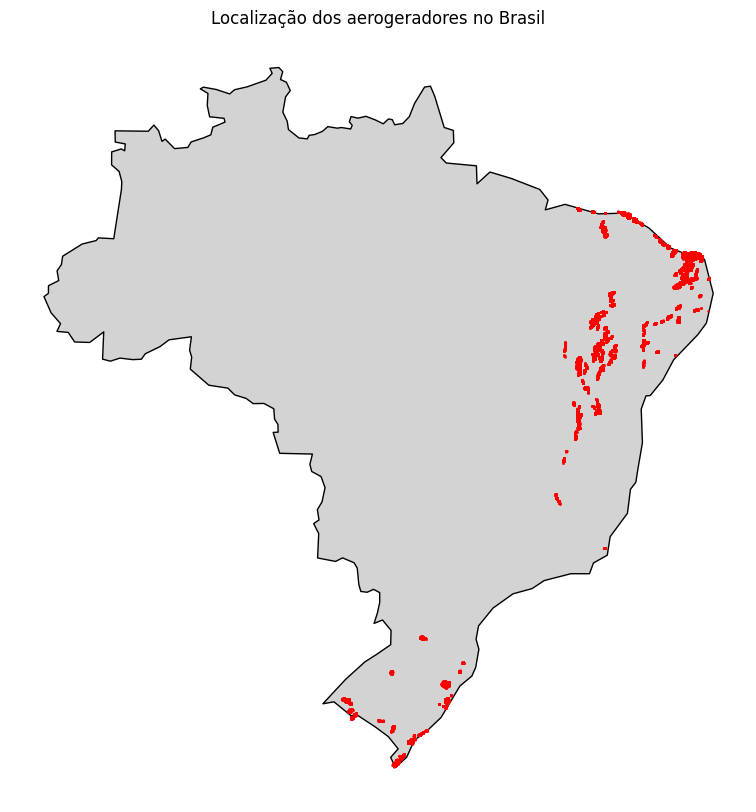

In [15]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o shapefile do mundo e filtrar apenas pelo Brasil
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
brazil = world[world['name'] == 'Brazil']

df = pd.read_csv(latest_csv)

# Converter o DataFrame em GeoDataFrame, definindo pontos a partir de latitude e longitude
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs="EPSG:4326"
)

gdf = gdf.to_crs(brazil.crs)

# Plotar o mapa do Brasil
fig, ax = plt.subplots(figsize=(10, 10))
brazil.plot(ax=ax, color='lightgrey', edgecolor='black')

# Sobrepor os pontos dos aerogeradores
gdf.plot(ax=ax, markersize=1, color='red', alpha=0.7)

# Ajustes finais
ax.set_title("Localização dos aerogeradores no Brasil")
ax.set_axis_off()

plt.show()


In [16]:
df.head()

,latitude,longitude,POT_MW,ALT_TOTAL,ALT_TORRE,DIAM_ROTOR,DATA_ATUALIZACAO,EOL_VERSAO_ID,NOME_EOL,DEN_AEG,...,Y,VERSAO,DATUM_EMP,OPERACAO,FUSO_AG,PROPRIETARIO,ORIGEM,OBJECTID,UF,CEG
0,-14.470968,-42.642495,1.85,121.25,80.0,82.5,2022-10-24,30739.0,Caititu,CAI-083,...,8398879.00,Versão Válida,WGS84,Sim,UTM 23 S (MER -45),Central Eólica Caititu S.A.,NaN,1,BA,EOLCVBA030739-4-01
1,-5.115754,-35.924469,2.00,145.00,95.0,100.0,2022-10-24,30512.0,Dreen Boa Vista,BV07,...,9433802.00,Versão Válida,SIRGAS2000,Sim,UTM 25 S (MER -33),GE Boa Vista S.A.,NaN,2,RN,EOLCVRN030512-0-01
2,-5.267424,-35.844373,2.00,145.00,95.0,100.0,2022-10-24,30497.0,Renascença V,15,...,9417056.00,Versão Válida,SIRGAS2000,Sim,UTM 25 S (MER -33),Renascença V Energias Renováveis S.A.,NaN,3,RN,EOLCVRN030497-2-01
3,-5.442082,-35.923294,2.70,150.00,89.0,122.0,2022-10-24,30864.0,SM,1,...,9397684.00,Versão Válida,SIRGAS2000,Sim,UTM 25 S (MER -33),Santa Maria Energias Renováveis S.A.,NaN,4,RN,EOLCVRN030864-1-01
4,-3.540330,-38.879826,2.10,143.70,96.2,95.0,2022-10-24,30295.0,Colônia,AEG-08,...,9608681.26,Versão Válida,SIRGAS2000,Sim,UTM 24 S (MER -39),Central Geradora Eólica Colônia S.A.,NaN,5,CE,EOLCVCE030295-3-01


In [17]:
df.dtypes

latitude            float64
longitude           float64
POT_MW              float64
ALT_TOTAL           float64
ALT_TORRE           float64
DIAM_ROTOR          float64
DATA_ATUALIZACAO     object
EOL_VERSAO_ID       float64
NOME_EOL             object
DEN_AEG              object
X                   float64
Y                   float64
VERSAO               object
DATUM_EMP            object
OPERACAO             object
FUSO_AG              object
PROPRIETARIO         object
ORIGEM              float64
OBJECTID              int64
UF                   object
CEG                  object
dtype: object

In [23]:
top_20 = df['POT_MW'].nlargest(80)
print(top_20)

11570    12.0
11571    12.0
11572    12.0
11573    12.0
11574    12.0
         ... 
15438     9.1
15439     9.1
15440     9.1
15441     9.1
15442     9.1
Name: POT_MW, Length: 80, dtype: float64


In [19]:
# 1. Create df1 with only rows where POT_MW > 1000
df1 = df[df['POT_MW'] > 1000]

# 3. Print df1 in full
print(df)

        latitude  longitude  POT_MW  ALT_TOTAL  ALT_TORRE  DIAM_ROTOR  \
0     -14.470968 -42.642495   1.850     121.25       80.0        82.5   
1      -5.115754 -35.924469   2.000     145.00       95.0       100.0   
2      -5.267424 -35.844373   2.000     145.00       95.0       100.0   
3      -5.442082 -35.923294   2.700     150.00       89.0       122.0   
4      -3.540330 -38.879826   2.100     143.70       96.2        95.0   
...          ...        ...     ...        ...        ...         ...   
23282 -30.847180 -55.704673   2.000     149.38      108.0        82.0   
23283 -14.223984 -42.641430   1.600     121.25       80.0        82.5   
23284  -8.908645 -41.595513   5.500     204.00      125.0       158.0   
23285  -5.176915 -36.011283   3.465     186.00      120.0       132.0   
23286  -5.062473 -37.043028   3.465     186.00      132.0       132.0   

      DATA_ATUALIZACAO  EOL_VERSAO_ID                NOME_EOL    DEN_AEG  ...  \
0           2022-10-24        30739.0     

In [20]:
df.head()

,latitude,longitude,POT_MW,ALT_TOTAL,ALT_TORRE,DIAM_ROTOR,DATA_ATUALIZACAO,EOL_VERSAO_ID,NOME_EOL,DEN_AEG,...,Y,VERSAO,DATUM_EMP,OPERACAO,FUSO_AG,PROPRIETARIO,ORIGEM,OBJECTID,UF,CEG
0,-14.470968,-42.642495,1.85,121.25,80.0,82.5,2022-10-24,30739.0,Caititu,CAI-083,...,8398879.00,Versão Válida,WGS84,Sim,UTM 23 S (MER -45),Central Eólica Caititu S.A.,NaN,1,BA,EOLCVBA030739-4-01
1,-5.115754,-35.924469,2.00,145.00,95.0,100.0,2022-10-24,30512.0,Dreen Boa Vista,BV07,...,9433802.00,Versão Válida,SIRGAS2000,Sim,UTM 25 S (MER -33),GE Boa Vista S.A.,NaN,2,RN,EOLCVRN030512-0-01
2,-5.267424,-35.844373,2.00,145.00,95.0,100.0,2022-10-24,30497.0,Renascença V,15,...,9417056.00,Versão Válida,SIRGAS2000,Sim,UTM 25 S (MER -33),Renascença V Energias Renováveis S.A.,NaN,3,RN,EOLCVRN030497-2-01
3,-5.442082,-35.923294,2.70,150.00,89.0,122.0,2022-10-24,30864.0,SM,1,...,9397684.00,Versão Válida,SIRGAS2000,Sim,UTM 25 S (MER -33),Santa Maria Energias Renováveis S.A.,NaN,4,RN,EOLCVRN030864-1-01
4,-3.540330,-38.879826,2.10,143.70,96.2,95.0,2022-10-24,30295.0,Colônia,AEG-08,...,9608681.26,Versão Válida,SIRGAS2000,Sim,UTM 24 S (MER -39),Central Geradora Eólica Colônia S.A.,NaN,5,CE,EOLCVCE030295-3-01


In [21]:
import pandas as pd

# Assuming your DataFrame is named df and the column is 'OPERACAO'

# 1. Get counts of each unique value in 'OPERACAO'
counts = df['UF'].value_counts(dropna=False)

# 2. (Optional) Turn that into a DataFrame for easier viewing/manipulation
counts_df = counts.rename_axis('UF').reset_index(name='count')

print(counts_df)


    UF  count
0   BA   8073
1   RN   5293
2   RS   2889
3   CE   2054
4   PI   1980
5   PB   1405
6   PE    738
7   MG    330
8   SC    194
9   MA    193
10  PR     76
11  SE     23
12  AL     22
13  RJ     17
